In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Calcul de la divergence bidimensionelle
"""
DataFolder="C:/Users/Julie_000/Desktop/Stage" 

# I-Champs bidimensionnels de vitesse by Clément

In [2]:
# Importation des librairies
from mat4py import loadmat #pour charger des .mat
import matplotlib
import matplotlib.pyplot as plt # pour tracer les figures
plt.rcParams['figure.figsize'] = [8, 4.5] # taille par dÃ©faut des figures qu'on trace
import os # pour modifier le dossier de travail
import numpy as np # pour travailler avec des array
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import sys
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver

import scipy as sc #pour l'analyse
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import MaxNLocator #pour le contour

## I-1) Définition des fonctions

In [3]:
# Definition des fonctions
def PIV(prof,manips): 
    """retourne les données des plans pour la bonne profondeur"""
    
    if prof==5:
        piv=manips['piv5']
    elif prof==10:
        piv=manips['piv10']
    elif prof==15:
        piv=manips['piv15']
    else:
        return("prof n'a pas une valeur acceptable")   
    return(piv)

def donnees(prof,plan,manips):
    """Retourne les tableaux de données pour le plan choisi de la profondeur donnée"""
    
    piv=PIV(prof,manips)
    u=np.array(piv[plan]['u'])
    v=np.array(piv[plan]['v'])
    x=np.array(piv[plan]['x'])
    y=np.array(piv[plan]['y'])
    return(u,v,x,y)

## I-2) Chargement des données

In [4]:
# Chargement des données:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

prof=10 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)
plan=2
    
u,v,x,y=donnees(prof, plan, manips)

## I-3) Plot du champ de vitesse d'un plan choisi pour une profondeur donnée

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


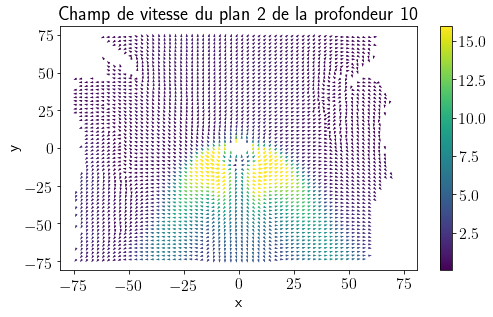

In [5]:
#%matplotlib notebook
"Tracé du champ de vitesse pour la profondeur et le plan choisi"

## Pour mieux les représenter, Clément bidouille la colormap
velocity=np.sqrt(u**2+v**2)
velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
colors = velocity
colors[velocity>velmax]=velmax
colormap=cm.magma#colormap je crois que cette commande ne fonctionne pas
norm = Normalize()
norm.autoscale(colors)
    
##plot    
plt.subplots() #pour pas que le plot soit remplacé à chaque fois
cb=plt.colorbar(plt.quiver(x,y,u/velocity,v/velocity,colors)) #pour la barre de couleur
plt.title("Champ de vitesse du plan {} de la profondeur {}".format(plan,prof))
plt.xlabel("x")
plt.ylabel("y")
plt.quiver(x,y,u/velocity,v/velocity,colors)#quiver pour plotter des champs de vecteurs

# II- Calcul de la divergence bidimensionnelle

## II-1) Approche naïve : différencier sans lisser

### II-1-1) Définition des fonctions


In [6]:
#Définition des fonctions

def deriv(y,x,axis):
    """Dérive un tableau 2D y par rapport à x suivant un axe donné"""
    if axis==0:
        return((y[1:,:]-y[:-1,:])/(x[1:,:]-x[:-1,:]))#Donc là le tableau est de taille (n-1,n)
    if axis==1:
        return((y[:,1:]-y[:,:-1])/(x[:,1:]-x[:,:-1]))#Donc là le tableau est de taille (n,n-1)
    return("deriv ne fonctionne que pour des tableaux 2D")
    

def abcisse(x,axis):
    """somme discrète x[i+1]+x[i]/2 suivant un axe donné"""
    if axis==0:
        return((x[1:,:]+x[:-1,:])/2)
    if axis==1:
        return((x[:,1:]+x[:,:-1])/2)
    return("abcisse ne fonctionne que pour des tableaux 2D")
        
    
def good_shape(a):
    "remise à la bonne shape des tableaux a et b pour pouvoir ensuite les sommer"
    "Ne fonctionne que dans ce cas précis avec des tableaux (n,n-1) et (n-1,n) et donne un tableau (n-1,n-1)"
    #donc on perd des données, je ne sais pas comment faire autrement...
    n=np.max(np.shape(a))
    if np.shape(a)[0]==n:
        return(a[:-1,:])
    if np.shape(a)[1]==n:
        return(a[:,:-1])
    return("les dimensions des array ne conviennent pas pour l'usage de good_shape, ou problème avec n")
 
    
def divergence2D(a,b):
    "juste somme d'array"
    if np.shape(a)==np.shape(b):
        return(a+b)
    return("les array n'ont pas la bonne shape")

### II-1-2) Chargement des tableaux

In [8]:
"Dérivation"
du,dv=deriv(u,x,1),deriv(v,y,0)
dx,dy=abcisse(x,1),abcisse(y,0)

"Remise à la bonne taille"
du,dv=good_shape(du),good_shape(dv)
dx,dy=good_shape(dx),good_shape(dy)

"somme des tableaux"
div = divergence2D(du,dv)
print(np.shape(dx))
print(np.max(div),np.min(div),np.mean(div),np.std(div))

(59, 59)
16.095015991682782 -11.845523747942098 0.01010813884451311 0.7041343297871878


### II-1-3) Premier plot

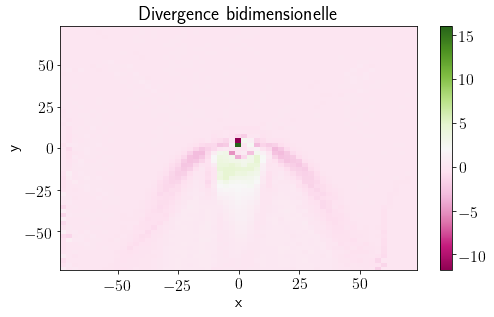

16.095015991682782 -11.845523747942098 0.01010813884451311 0.7041343297871878


In [9]:
#%matplotlib notebook
colors_div = div
colormap2=cm.PiYG#colormap

    
#plot 
fig,ax=plt.subplots(nrows=1)
im=ax.pcolormesh(x,y,div,cmap=colormap2)
ax.set_title("Divergence bidimensionelle")
fig.colorbar(im, ax=ax)
plt.xlabel("x")
plt.ylabel("y")

plt.show()

print(np.max(div),np.min(div),np.mean(div),np.std(div))

"`piste qui ne donne rien pour l'instant`"
#bidouillage
divmax=np.mean(div)+np.std(div)#norme maximale représentée sur la colormap borne sup arbitraire
colors_div[div>divmax]=divmax

#plot
plt.subplots()
plt.title("Divergence bidimensionelle2")
plt.xlabel("x")
plt.ylabel("y")
plt.pcolormesh(x,y,div,cmap=colormap,norm=norm)
plt.show()


### II-1-4) Représentation et affinage
#### a-Superposition du nageur

Ici le but est d'enlever les données qui ne correspondent à rien sous le nageur. On enlève donc une zone de 5x5mm^2 soit donc 12x12 pixels centrée en 0. Je remplace cette zone par des 0, ce qui devrait apparaître blanc et correspond à peu près à la moyenne

In [10]:
#definition des fonctions

def masque(a):
    "Enlève les données sous le nageur"
    b=a
    b[27:33,27:33]=np.zeros((6,6))
    return(b)

div_masque=masque(div)
div = divergence2D(du,dv) #Je ne comprends pas pourquoi j'ai besoin de cette ligne pour ne pas écraser div

#lignes pour voir si div et div_masque sont toujours différents
print(np.max(div_masque),np.min(div_masque),np.mean(div_masque),np.std(div_masque))
print(np.max(div),np.min(div),np.mean(div),np.std(div))
print(np.max(div-div_masque))

4.826524900595196 -3.217848651968189 0.00683726656630734 0.5795074540474114
16.095015991682782 -11.845523747942098 0.01010813884451311 0.7041343297871878
16.095015991682782


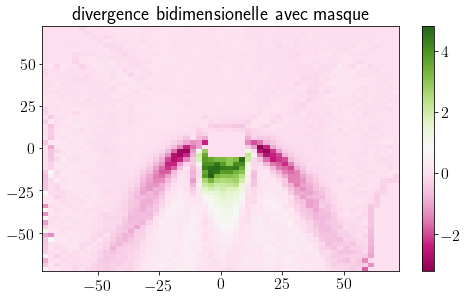

In [11]:
#%matplotlib notebook
#plot

fig, ax = plt.subplots(nrows=1)
im = ax.pcolormesh(dx, dy, div_masque, cmap=colormap2)
fig.colorbar(im, ax=ax)
ax.set_title('divergence bidimensionelle avec masque')
plt.show()

C'est pas mal !

#### b-Courbes de niveau

<IPython.core.display.Javascript object>


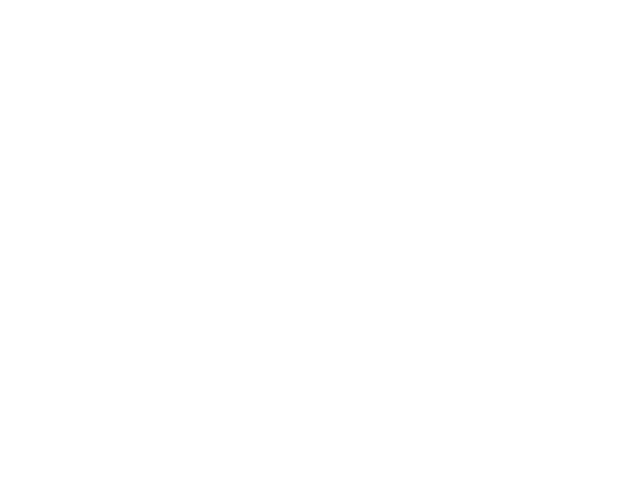

In [12]:
%matplotlib notebook
fig, (ax0,ax1) = plt.subplots(ncols=2)

#résolution (changer nbins)
levels = MaxNLocator(nbins=25).tick_values(div_masque.min(), div_masque.max())
levels2 = MaxNLocator(nbins=25).tick_values(div.min(), div.max())



# plot
cf0 = ax0.contourf(dx,dy,div,levels=levels2, cmap=colormap2)
fig.colorbar(cf0, ax=ax0)
ax0.set_title('Divergence avec courbes de niveau')

cf1 = ax1.contourf(dx,dy,div_masque,levels=levels, cmap=colormap2)
fig.colorbar(cf1, ax=ax1)
ax1.set_title('Divergence avec courbes de niveau et masque')

plt.show()

#### c-Ajout champ de vitesse
superposition du champ de vitesse sur la divergence

<IPython.core.display.Javascript object>


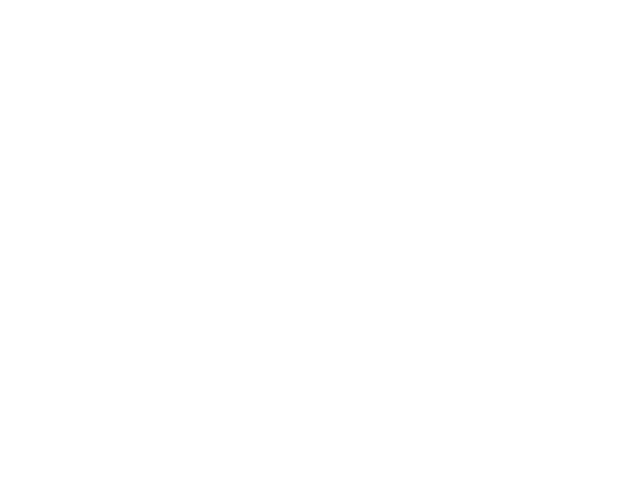

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [13]:
%matplotlib notebook

fig,(ax0,ax1)=plt.subplots(nrows=2)

#ax0 avec colormap, potentiellement à changer
cf0 = ax0.contourf(dx,dy,div_masque,levels=levels, cmap=colormap2)
fig.colorbar(cf0, ax=ax0)

im0=ax0.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],colors[::2,::2])
fig.colorbar(im0, ax=ax0)

ax0.set_title('Superposition avec colormap')

#ax1 sans colormap
cf1= ax1.contourf(dx,dy,div_masque,levels=levels, cmap=colormap2)
fig.colorbar(cf1, ax=ax1)

im1=ax1.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],color='k',scale=50)

ax1.set_title('Superposition sans colormap')

plt.tight_layout()
plt.show()

lignes de champ peut-être à tenter

# III- Application d'un Filtre Gaussien
## III-1) Définition des fonctions
#### a-Fonctions d'analyse

In [14]:
#définition des fonctions mathématiques

def masque_puis_filtregauss(a,sigma):
    "Applique le masque puis le filtre gaussien et s'adapte à la taille de sigma"
    if np.size(sigma)==1:
        return(gaussian_filter(masque(a),sigma))
    else :
        return("sigma n'a pas la bonne taille")

    

def filtregauss_puis_masque(a,sigma):
    "Applique le filtre gaussien puis le masque et s'adapte à la taille de sigma"
    if np.size(sigma)==1:
        return(masque(gaussian_filter(a,sigma)))
    else :
        return("sigma n'a pas la bonne taille")
    
    

def Filtres(sigmas,div, ordre) :
    "Tableau des divergence filtrées suivant l'odre donné : 0 pour le masque d'abord, 1 pour le filtre d'abord"
    #boucle de création des tableaux
    l=np.shape(sigmas)[0]
    n=np.shape(div)[0]
    Filtres=np.zeros((l,n,n))#création du tableau de tableau
    if ordre==0:
        for i in range(np.shape(sigmas)[0]):
            Filtres[i]=masque_puis_filtregauss(div,sigmas[i])
        return(Filtres)
    
    elif ordre==1:
        for i in range(np.shape(sigmas)[0]):
            Filtres[i]=filtregauss_puis_masque(div,sigmas[i])
        return(Filtres)
    return("order n'a pas la bonne valeur")
               

#### b-Fonctions de tracés

In [15]:
#définitions des fonctions de tracés

def plot_applications_filtre(div_filter0,div_filter1,div_filter2):
    "Fonction pour plot la divergence avec différents paramètres"
    fig, (l0,l1,l2) = plt.subplots(nrows=3,ncols=2,num='Différentes applications du filtre Gaussien')
    #l0 : Brut
    im0=l0[0].pcolormesh(x,y,div_filter0,cmap=colormap2)
    l0[0].set_title("Brut")
    im1 = l0[1].contourf(dx,dy,div_filter0,levels=levels2, cmap=colormap2)
    l0[1].set_title("Brut avec courbe de niveau")
    #l1 : avec masque0
    im2=l1[0].pcolormesh(x,y,div_filter1,cmap=colormap2)
    l1[0].set_title("Avec masque0")
    im3 = l1[1].contourf(dx,dy,div_filter1,levels=levels, cmap=colormap2)
    l1[1].set_title("Avec masque0 et courbes de niveau")
    #l1 : avec masque1
    im4=l2[0].pcolormesh(x,y,div_filter2,cmap=colormap2)
    l2[0].set_title("Avec masque1")
    im5 = l2[1].contourf(dx,dy,div_filter2,levels=levels, cmap=colormap2)
    l2[1].set_title("Avec masque1 et courbes de niveau")

    fig.tight_layout(pad=0.001)
    plt.show()
    
    
    
def plot_differents_filtrages(Filtres,sigmas,n,titre):
    "Fonction de tracé de filtres pour n=4 sigmas différents"
    if n==4:
        fig, (l0,l1,l2,l3) = plt.subplots(nrows=4,ncols=2,num=titre)
        #l0
        im0=l0[0].pcolormesh(x,y,Filtres[0],cmap=colormap2)
        l0[0].set_title("sigma={} brut".format(sigmas[0]))
        im1 = l0[1].contourf(dx,dy,Filtres[0],levels=levels, cmap=colormap2)
        l0[1].set_title("sigma={} courbes de niveau".format(sigmas[0]))
        #l1
        im2=l1[0].pcolormesh(x,y,Filtres[1],cmap=colormap2)
        l1[0].set_title("sigma={} brut".format(sigmas[1]))
        im3 = l1[1].contourf(dx,dy,Filtres[1],levels=levels, cmap=colormap2)
        l1[1].set_title("sigma={} courbes de niveau".format(sigmas[1]))
        #l2
        im4=l2[0].pcolormesh(x,y,Filtres[2],cmap=colormap2)
        l2[0].set_title("sigma={} brut".format(sigmas[2]))
        im5 = l2[1].contourf(dx,dy,Filtres[2],levels=levels, cmap=colormap2)
        l2[1].set_title("sigma={} courbes de niveau".format(sigmas[2]))
        #l3
        im6=l3[0].pcolormesh(x,y,Filtres[3],cmap=colormap2)
        l3[0].set_title("sigma={} brut".format(sigmas[3]))
        im7 = l3[1].contourf(dx,dy,Filtres[3],levels=levels, cmap=colormap2)
        l3[1].set_title("sigma={} courbes de niveau".format(sigmas[3]))

        #fig.tight_layout(pad=0.0001) #à améliorer
        plt.show()
        
    else:
        print("Tu n'as pas n=4")

## III-2) Application du filtre sur la divergence
### III-2-1) Application à différents endroits
#### a-Constitution des tableaux

In [16]:
#choix de sigma
sigma=0.5

#Chargement des tableaux
div_filter0=gaussian_filter(div,sigma) #on applique sur div original
div_filter1=masque_puis_filtregauss(div,sigma) #sur div avec masque
div_filter2=filtregauss_puis_masque(div,sigma)#D'abord sur div original puis on applique le masque


div = divergence2D(du,dv) #Je ne comprends pas pourquoi j'ai besoin de cette ligne pour ne pas écraser div
#lignes pour voir si div et div_masque sont toujours différents
print(np.max(div_masque),np.min(div_masque),np.mean(div_masque),np.std(div_masque))
print(np.max(div),np.min(div),np.mean(div),np.std(div))
print(np.max(div-div_masque))


4.826524900595196 -3.217848651968189 0.00683726656630734 0.5795074540474114
16.095015991682782 -11.845523747942098 0.01010813884451311 0.7041343297871878
16.095015991682782


#### b-Plots

<IPython.core.display.Javascript object>


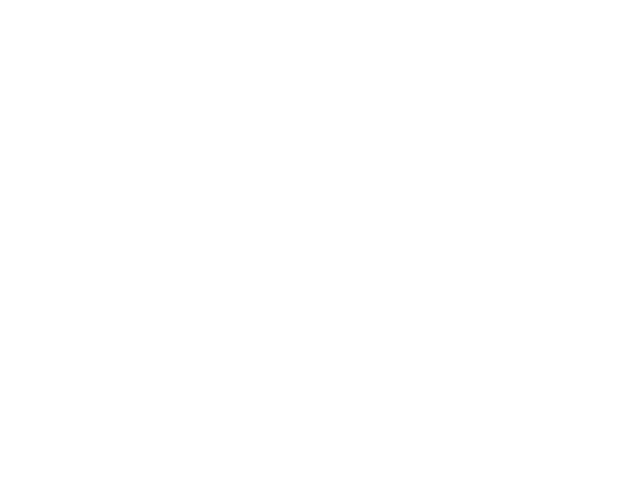

In [17]:
%matplotlib notebook

plot_applications_filtre(div_filter0,div_filter1,div_filter2)

La présence du masque est déterminante comme on l'avait vu plus tôt, mais la différence entre l'application du filtre avant ou après n'est pour l'instant pas significative.

### III-2-2) Application de différents sigmas

Je choisis de l'appliquer pour les 2 ordres d'application du masque et du filtrage

#### a-Dans l'ordre "masque puis filtrage"

Constitution des tableaux : 

In [21]:
#choix des différents sigmas
sigmas=np.arange(0,4,1)
n=np.size(sigmas)

#constitution du tableau de filtres
Filtres=Filtres(sigmas,div,0)#order = 0 pour le masque d'abord 


#print(sigmas,np.shape(Filtres))#tests
#print(Filtres)#tests

print(np.shape(Filtres))
print("n={}".format(n))

print(np.max(Filtres[0]-Filtres[3]))

TypeError: 'numpy.ndarray' object is not callable

Plots :

In [19]:
%matplotlib notebook
#on va essayer de garder un n=4 pour des raisons de praticité 

plot_differents_filtrages(Filtres,sigmas,n,"Filtrage pour différents sigmas, masque puis filtrage")

<IPython.core.display.Javascript object>

#### b-Dans l'ordre "filtrage puis masque"

Constitution des tableaux :

In [20]:
Filtres1=Filtres(sigmas,div,1)#création du tableau de tableau, order = 1 pour filtre puis masque

print(sigmas)   
print("n={}".format(n))

TypeError: 'numpy.ndarray' object is not callable

Plots :

In [ ]:
#%matplotlib notebook

plot_differents_filtrages(Filtres1,sigmas,n) #comprends pas pourquoi il ne me l'affiche pas (marche sur spyder)

## III-3) Application du filtre avant la divergence
### III-3-1) Définition des fonctions
#### a-Fonctions d'analyse

In [ ]:
def dUfiltre(Ufiltre,x,axis):
    "Dérive et remet à la bonne taille donne un tableau (l,n-1,n-1)"
    l=np.shape(Ufiltre)[0]
    n=np.shape(Ufiltre)[1]
    dU=np.zeros((l,n-1,n-1))
    for i in range(l):
        dU[i]=good_shape(deriv(Ufiltre[i], x, axis))
    return(dU)


def somme3D(a,b):
    "somme les tableaux a et b suivant le premier axe"
    S=np.zeros(np.shape(a))
    if np.shape(a)==np.shape(b):
        l=np.shape(a)[0]
        for i in range(l):
            S[i]=a[i]+b[i]
        return(S)
    else:
        return("a et b n'ont pas la même shape")
            

### III-2-2) Constitution des tableaux

In [ ]:
"Filtrage tableaux de départ"
Ufiltre0=Filtres(sigmas,u,0)#masque puis filtre
Ufiltre1=Filtres(sigmas,u,1)#filtre puis masque
Vfiltre0=Filtres(sigmas,v,0)
Vfiltre1=Filtres(sigmas,v,1)

"Dérivation"
dUfiltre0=dUfiltre(Ufiltre0, x, 1)
dUfiltre1=dUfiltre(Ufiltre1, x, 1)
dVfiltre0=dUfiltre(Ufiltre0, y, 0)
dVfiltre1=dUfiltre(Ufiltre1, y, 0)

"somme des tableaux"
div0=somme3D(dUfiltre0,dVfiltre0)#masque puis filtre
div1=somme3D(dUfiltre1,dVfiltre1#filtre puis masque

### III-2-3) Tracés

In [ ]:
plot_differents_filtrages(div0,sigmas,n,"Divergence filtrée en amont, masque puis filtre")

In [ ]:
plot_differents_filtrages(div1,sigmas,n,"Divergence filtrée en amont, filtre puis masque")

**Trucs à faire dans un futur plus ou moins proche**

-tenter les lignes de champ

-résoudre problèmes taille flèches en quiver

-résoudre la question de la colormap en quiver

-trouver comment label juste une ligne

-moyen de faire une boucle pour tracer les 1000 subplots ?

-ajouter titre aux fonctions de plot

-importer notebook ?
